<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-04-10 05:01:43--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.001s  

2020-04-10 05:01:43 (14.9 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [ ]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

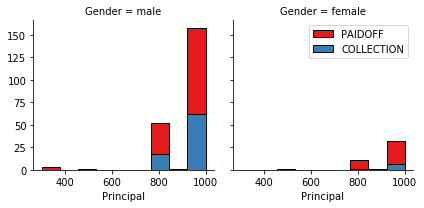

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

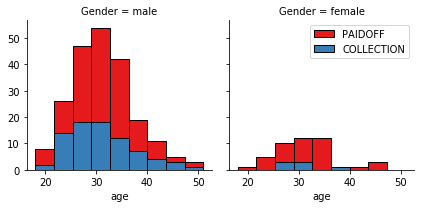

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

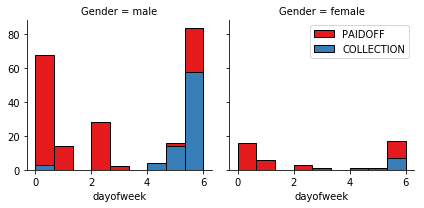

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
print(Feature.head())


   Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       1000     30   45       0        0         0                     1   
1       1000     30   33       1        0         1                     0   
2       1000     15   27       0        0         0                     0   
3       1000     30   28       1        1         0                     0   
4       1000     30   29       0        1         0                     0   

   college  
0        0  
1        0  
2        1  
3        1  
4        1  


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]
!pip install graphviz

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

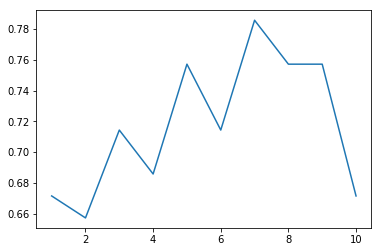

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
accuracy=[]
for k in range(10):
    model = KNeighborsClassifier(n_neighbors = k+1).fit(X_train,y_train)
    yhat=model.predict(X_test)
    accuracy.append(metrics.accuracy_score(y_test, yhat))
plt.plot(np.arange(1,11),accuracy,label="Accuracy")
plt.show()


In [21]:
print("The optimal k value is :",accuracy.index(max(accuracy)) + 1)

The optimal k value is : 7


In [22]:
bestknn = KNeighborsClassifier(n_neighbors = 7).fit(X_train,y_train)
yhat = bestknn.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, bestknn.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
from sklearn.metrics import classification_report
print (classification_report(y_test, yhat))
from sklearn.metrics import confusion_matrix
print (confusion_matrix(y_test, yhat))
from sklearn.metrics import f1_score
print("f1 score is:",f1_score(y_test, yhat, average='weighted'))
from sklearn.metrics import jaccard_similarity_score
print("Jaccard score is:",jaccard_similarity_score(y_test, yhat))

Train set Accuracy:  0.8079710144927537
Test set Accuracy:  0.7857142857142857
              precision    recall  f1-score   support

  COLLECTION       0.50      0.40      0.44        15
     PAIDOFF       0.84      0.89      0.87        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.67      0.65      0.66        70
weighted avg       0.77      0.79      0.78        70

[[ 6  9]
 [ 6 49]]
f1 score is: 0.7766540244416351
Jaccard score is: 0.7857142857142857


# Decision Tree

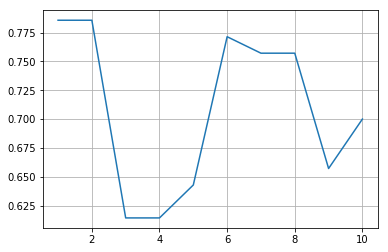

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
accuracy_tree=[]
for depth in range(10):
    model_tree = DecisionTreeClassifier(criterion="entropy", max_depth = depth+1).fit(X_train,y_train)
    yhat_tree=model_tree.predict(X_test)
    accuracy_tree.append(metrics.accuracy_score(y_test, yhat_tree))
plt.plot(np.arange(1,11),accuracy_tree,label="Accuracy")
plt.grid()
plt.show()

In [25]:
bestree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
bestree.fit(X_train,y_train)
yhat_tree= bestree.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

Train set Accuracy:  0.7753623188405797
Test set Accuracy:  0.7714285714285715
              precision    recall  f1-score   support

  COLLECTION       0.33      0.07      0.11        15
     PAIDOFF       0.79      0.96      0.87        55

   micro avg       0.77      0.77      0.77        70
   macro avg       0.56      0.52      0.49        70
weighted avg       0.69      0.77      0.71        70

f1 score is: 0.7064793130366899
Jaccard score is: 0.7714285714285715


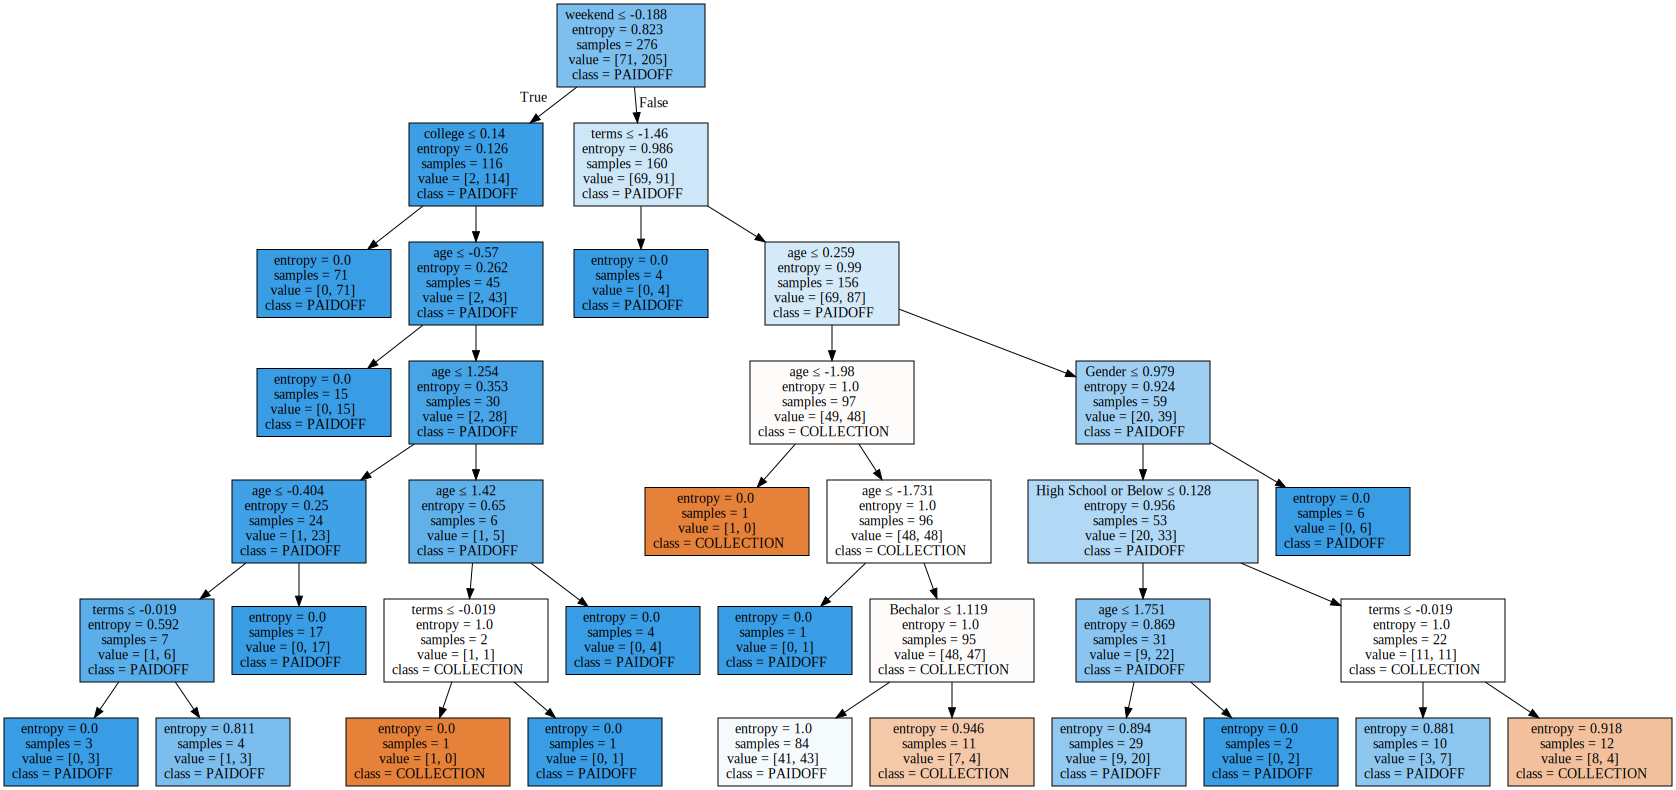

In [26]:
import sklearn, graphviz
print("Train set Accuracy: ", metrics.accuracy_score(y_train, bestree.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_tree))
print(classification_report(y_test, yhat_tree))
print("f1 score is:",f1_score(y_test, yhat_tree, average='weighted'))
print("Jaccard score is:",jaccard_similarity_score(y_test, yhat_tree))
g=sklearn.tree.export_graphviz(bestree,feature_names=Feature.columns.values, class_names=np.unique(y_train), filled=True, special_characters=True, rotate=False)
d=graphviz.Source(g)
d

# Support Vector Machine

In [27]:
from sklearn import svm

svm1 = svm.SVC(kernel='rbf').fit(X_train, y_train)
yhat1 = svm1.predict(X_test)
svm_r = metrics.accuracy_score(y_test, yhat1)

svm2 = svm.SVC(kernel='linear').fit(X_train, y_train)
yhat2 = svm2.predict(X_test)
svm_l = metrics.accuracy_score(y_test, yhat2)
    
svm3 = svm.SVC(kernel='poly').fit(X_train, y_train)
yhat3 = svm3.predict(X_test)
svm_p = metrics.accuracy_score(y_test, yhat3)

svm4 = svm.SVC(kernel='sigmoid').fit(X_train, y_train)
yhat4 = svm4.predict(X_test)
svm_s = metrics.accuracy_score(y_test, yhat4)
    
print("Radial Accuarcy:",svm_r)
print("Linear Accuracy:",svm_l)
print("Polynomial Accuracy:",svm_p)
print("Sigmoid Accuracy:",svm_s)

Radial Accuarcy: 0.7428571428571429
Linear Accuracy: 0.7857142857142857
Polynomial Accuracy: 0.7714285714285715
Sigmoid Accuracy: 0.7428571428571429


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [28]:
# Linear kernel shows best accuracy and thus best model, but:
print(set(y_test))
# Find if labels are missing in the SVM models 
print("The label missing in the first model with rbf kernel:",set(y_test) - set(yhat1))
print("The label missing in the second model with linear:",set(y_test) - set(yhat2))
print("The label missing in the third model with polynomial kernel:",set(y_test) - set(yhat3))
print("The label missing in the fourth model with sigmoid kernel:",set(y_test) - set(yhat4))

{'COLLECTION', 'PAIDOFF'}
The label missing in the first model with rbf kernel: set()
The label missing in the second model with linear: {'COLLECTION'}
The label missing in the third model with polynomial kernel: set()
The label missing in the fourth model with sigmoid kernel: set()


In [29]:
#The predicted values of the SVM classifiers with a linear kernel has predicted all the values as paid off and ignored collection hence these wont be a good model.
# Also looking at the values polynomial kernel classy one data as classification and others as paidoff
# Hence rbf kernel is the best
bestsvm = svm.SVC(kernel='rbf').fit(X_train, y_train)
yhat = bestsvm.predict(X_test)
print(yhat[0:5])
print("Train set Accuracy: ", metrics.accuracy_score(y_train, bestsvm.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
print(classification_report(y_test, yhat))
print("f1 score is:",f1_score(y_test, yhat, average='weighted'))
print("Jaccard score is:",jaccard_similarity_score(y_test, yhat))

['COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Train set Accuracy:  0.782608695652174
Test set Accuracy:  0.7428571428571429
              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

   micro avg       0.74      0.74      0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

f1 score is: 0.7275882012724117
Jaccard score is: 0.7428571428571429


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


# Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression

lr1 = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat1 = lr1.predict(X_test)
lr_a1 = metrics.accuracy_score(y_test, yhat1)

lr2 = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
yhat2 = lr2.predict(X_test)
lr_a2 = metrics.accuracy_score(y_test, yhat2)

lr3 = LogisticRegression(C=0.01, solver='saga').fit(X_train,y_train)
yhat3 = lr3.predict(X_test)
lr_a3 = metrics.accuracy_score(y_test, yhat3)

lr4 = LogisticRegression(C=0.01, solver='newton-cg').fit(X_train,y_train)
yhat4 = lr4.predict(X_test)
lr_a4 = metrics.accuracy_score(y_test, yhat4)

lr5 = LogisticRegression(C=0.01, solver='lbfgs').fit(X_train,y_train)
yhat5 = lr5.predict(X_test)
lr_a5 = metrics.accuracy_score(y_test, yhat5)


print('LR model with liblinear solver',lr_a1)
print('LR model with sag solver',lr_a2)
print('LR model with saga solver',lr_a3)
print('LR model with newton-cg solver',lr_a4)
print('LR model with lbfgs solver',lr_a5)


LR model with liblinear solver 0.6857142857142857
LR model with sag solver 0.7857142857142857
LR model with saga solver 0.7857142857142857
LR model with newton-cg solver 0.7857142857142857
LR model with lbfgs solver 0.7857142857142857


In [31]:
# Find if labels are missing in the models 
print("The label missing in the LR model with liblinear solver",set(y_test) - set(yhat1))
print("The label missing in the LR model with sag solver",set(y_test) - set(yhat2))
print("The label missing in the LR model with saga solver",set(y_test) - set(yhat3))
print("The label missing in the LR model with newton-cg solver",set(y_test) - set(yhat4))
print("The label missing in the LR model with lbfgs solver",set(y_test) - set(yhat5))

The label missing in the LR model with liblinear solver set()
The label missing in the LR model with sag solver {'COLLECTION'}
The label missing in the LR model with saga solver {'COLLECTION'}
The label missing in the LR model with newton-cg solver {'COLLECTION'}
The label missing in the LR model with lbfgs solver {'COLLECTION'}


In [32]:
#Except for the liblinear solver all other model has skipped the lable "collection" from the predicted values. Hence, the best logistic classifier will be the one with a liblinear solver.¶
bestlr = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat = bestlr.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, bestlr.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
print(classification_report(y_test, yhat))
print("f1 score is:",f1_score(y_test, yhat, average='weighted'))
print("Jaccard score is:",jaccard_similarity_score(y_test, yhat))

Train set Accuracy:  0.7572463768115942
Test set Accuracy:  0.6857142857142857
              precision    recall  f1-score   support

  COLLECTION       0.18      0.13      0.15        15
     PAIDOFF       0.78      0.84      0.81        55

   micro avg       0.69      0.69      0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70

f1 score is: 0.6670522459996144
Jaccard score is: 0.6857142857142857


# Model Evaluation using Test set

In [33]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [34]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-04-10 05:03:14--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-04-10 05:03:14 (352 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [35]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [36]:
df = test_df

df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df['dayofweek'] = df['effective_date'].dt.dayofweek
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

df.groupby(['education'])['loan_status'].value_counts(normalize=True)

Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

X_test = Feature

y_test = df['loan_status'].values

X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:21: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


In [41]:
# KNN model
yhat_knn = bestknn.predict(X_test)

f1_knn = f1_score(y_test, yhat_knn, average='weighted') 

jsc_knn = jaccard_similarity_score(y_test, yhat_knn)

print('f1 score_knn: ',f1_knn)
print('Jaccard index_knn: ',jsc_knn)

# Decision Tree model
yhat_dt= bestree.predict(X_test)

# Calculate the f1 score
f1_dt = f1_score(y_test, yhat_dt, average='weighted') 

#Calculate the Jaccard index# Predict using the model
jsc_dt = jaccard_similarity_score(y_test, yhat_dt)

print('f1 score_tree: ',f1_dt)
print('Jaccard index_tree: ',jsc_dt)

# SVM Model
yhat_svm = bestsvm.predict(X_test)

# Calculate the f1 score
f1_svm = f1_score(y_test, yhat_svm, average='weighted') 

#Calculate the Jaccard index# Predict using the model
jsc_svm = jaccard_similarity_score(y_test, yhat_svm)

print('f1 score_SVM: ',f1_svm)
print('Jaccard index_SVM: ',jsc_svm)

# Logistic Regression Model
yhat_lr = bestlr.predict(X_test)

# Calculate the f1 score
f1_lr = f1_score(y_test, yhat_lr, average='weighted') 

#Calculate the Jaccard index# Predict using the model
jsc_lr = jaccard_similarity_score(y_test, yhat_lr)

# Calculate Log loss
yhat_lr_prob = bestlr.predict_proba(X_test)
ll_lr = log_loss(y_test, yhat_lr_prob)


print('f1 score_lr: ',f1_lr)
print('Jaccard index_lr: ',jsc_lr)
print('Log Loss_lr: ',ll_lr)

f1 score_knn:  0.6328400281888654
Jaccard index_knn:  0.6666666666666666
f1 score_tree:  0.6704776923582364
Jaccard index_tree:  0.7222222222222222
f1 score_SVM:  0.7583503077293734
Jaccard index_SVM:  0.7962962962962963
f1 score_lr:  0.6604267310789049
Jaccard index_lr:  0.7407407407407407
Log Loss_lr:  0.5672153379912981


In [42]:
Jaccard = [jsc_knn,jsc_dt,jsc_svm,jsc_lr]
F1_score = [f1_knn,f1_dt,f1_svm,f1_lr]
LogLoss = ['NA','NA','NA',ll_lr]

    
df = {'Algorithm': ['KNN', 'Decistion Tree', 'SVM', 'LogisticRegression'], \
     'Jaccard': Jaccard, 'F1-score': F1_score, 'LogLoss': LogLoss}

Report = pd.DataFrame(data=df, columns=['Algorithm', 'Jaccard', 'F1-score', 'LogLoss'], index=None)
Report

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.666667,0.632840,NA
1,Decistion Tree,0.722222,0.670478,NA
2,SVM,0.796296,0.758350,NA
3,LogisticRegression,0.740741,0.660427,0.567215


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>